<a href="https://colab.research.google.com/github/Chaika2/blank-app-template-dxrbl4o581m/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22ML_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
# Импортируем библиотеку pandas для работы с данными в формате CSV
import pandas as pd
# Читаем данные из файла 'train.csv' и сохраняем их в переменную df
df = pd.read_csv('/content/ML/train.csv')
# Импортируем функцию train_test_split из библиотеки sklearn.model_selection
from sklearn.model_selection import train_test_split
# Делим данные из df на тренировочную и тестовую выборки размер тестовой выборки составляет 20% от общих данных Используем seed 28 для воспроизводимости результатов
train_data, test_data = train_test_split(df, test_size=0.2, random_state=28)
# Далее делим тестовую выборку на две части: валидационную и тестовуюРазмер валидационной выборки составляет 40% от тестовой выборкиИспользуем seed 42 для воспроизводимости результатов
test_data, val_data = train_test_split(test_data, test_size=0.4, random_state=42)

In [4]:
#Эта функция принимает на вход dataframe (DataFrame), шаг перемешивания данных (shuffle) и размер пакета (batch_size).
#Она создает tf.data.Dataset из данных DataFrame, извлекая признаки и метки.
#Если shuffle установлен в True, то перемешивает данные.
#Затем она разбивает данные на пакеты размером batch_size и предварительно подгружает данные, используя tf.data.AUTOTUNE для оптимизации производительности.
def df_dataset(dataframe, shuffle=True, batch_size = 32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    dataset = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset
#Здесь мы создаем тренировочный и тестовый наборы данных, используя функцию df_dataset. Тренировочный набор данных перемешивается, а тестовый - нет.
train_dataset = df_dataset(train_data)
test_dataset = df_dataset(test_data, shuffle=False)
#Эти строки определяют имена столбцов для признаков (пиксели) и метки.
pixels = [ f'pixel{i}' for i in range(784) ]
columns = pixels +['label']
#Эта функция preproc_fn выполняет предварительную обработку данных.
#Она извлекает пиксели изображения из словаря признаков, преобразует их в тензор 4D формы [batch_size, 28, 28, 1] (серые изображения), нормализует значения пикселей от 0 до 1.
def preproc_fn(features, label):
    img_pixels = [features[col] for col in pixels]
    img_pixels = tf.stack(img_pixels, axis = 1)
    img_pixels = tf.reshape(img_pixels, shape=[-1,28,28,1])
    img_pixels = tf.cast(img_pixels, tf.float32) / 255.0
    return img_pixels, label
#Здесь мы применяем функцию preproc_fn к тренировочному и тестовому наборам данных, чтобы предварительно обработать изображения.
test_dataset = test_dataset.map(preproc_fn)
train_dataset = train_dataset.map(preproc_fn)
#Вывод
def print_shapes(features, label):
    tf.print("Features shape:", tf.shape(features))
    tf.print("Label shape:", tf.shape(label))
    return features, label

In [5]:
Y_train = train_data.pop('label')
# Извлекает столбец 'label' из DataFrame 'train_data' и присваивает его переменной 'Y_train'. Это представляет целевую переменную или истинные метки для обучающих данных.
Y_train = Y_train.astype(int)
# Преобразует данные 'Y_train' из типа по умолчанию (обычно float или object) в целочисленный тип.
X_train = train_data.astype(float)
# Преобразует DataFrame 'train_data' (за исключением столбца 'label', который был удален ранее) в тип float. Это представляет собой входные данные или признаки для обучающего набора.
X_train = X_train/255.0
# Нормализует данные 'X_train', разделив каждый элемент на 255.0. Это распространенный предварительный этап обработки для масштабирования значений пикселей между 0 и 1.
X_train = X_train.values.reshape(-1,28,28,1)
# Преобразует данные 'X_train' в 4-мерный тензор с формой (num_samples, 28, 28, 1). Это ожидаемый формат ввода для многих моделей глубокого обучения, где последнее измерение представляет количество каналов цвета (в данном случае один канал для изображений в оттенках серого).
Y_val = val_data.pop('label')
# Извлекает столбец 'label' из DataFrame 'val_data' и присваивает его переменной 'Y_val'. Это представляет целевую переменную или истинные метки для валидационных данных.
X_val = val_data.astype(float).values.reshape(-1,28,28,1)/255.0
# Преобразует DataFrame 'val_data' в тип float, преобразует его в 4-мерный тензор, как 'X_train', и нормализует значения пикселей, разделив на 255.0. Это представляет собой входные данные или признаки для валидационного набора.
Y_val = Y_val.astype(int)
# Преобразует данные 'Y_val' из типа по умолчанию в целочисленный тип.
Y_test = test_data.pop('label')
# Извлекает столбец 'label' из DataFrame 'test_data' и присваивает его переменной 'Y_test'. Это представляет целевую переменную или истинные метки для тестовых данных.
X_test = test_data.astype(float).values.reshape(-1,28,28,1)
# Преобразует DataFrame 'test_data' в тип float, преобразует его в 4-мерный тензор, как 'X_train', и нормализует значения пикселей, разделив на 255.0. Это представляет собой входные данные или признаки для тестового набора.
Y_test = Y_test.astype(int)
# Преобразует данные 'Y_test' из типа по умолчанию в целочисленный тип.

In [36]:
model = keras.Sequential([keras.layers.InputLayer(input_shape= (28,28, 1)), # Создается последовательная модель, которая представляет архитектуру нейронной сети. Определяется входной слой модели с размерностью (28, 28, 1)(ЧБ картинки)
                          keras.layers.Conv2D(32,kernel_size=(6,6), activation ='relu', padding='same'),# Добавляется сверточный слой с 32 фильтрами размером 6x6, активационной функцией ReLU и режимом "same" для заполнения границ.
                          keras.layers.MaxPooling2D(pool_size=(2,2)),# Добавляется слой максимального объединения (max pooling) с размером ядра 2x2.
                          keras.layers.Dropout(.25),# Добавляется слой регуляризации Dropout с вероятностью 0.25.
                          keras.layers.Conv2D(32,kernel_size=(6,6), activation ='relu', padding='same'),# Добавляется еще один сверточный слой с 32 фильтрами размером 6x6, активационной функцией ReLU и режимом "same".
                          keras.layers.MaxPooling2D(pool_size=(2,2)),# Добавляется еще один слой максимального объединения с размером ядра 2x2.
                          keras.layers.Dropout(.3),# Добавляется еще один слой регуляризации Dropout с вероятностью 0.3.
                          keras.layers.Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'),# Добавляется сверточный слой с 64 фильтрами размером 3x3, активационной функцией ReLU и режимом "same".
                          keras.layers.MaxPooling2D(pool_size=(2,2)),# Добавляется еще один слой максимального объединения с размером ядра 2x2.
                          keras.layers.Dropout(.25),# Добавляется еще один слой регуляризации Dropout с вероятностью 0.25.
                          keras.layers.Conv2D(64,kernel_size=(3,3), activation ='relu', padding='same'),# Добавляется еще один сверточный слой с 64 фильтрами размером 3x3, активационной функцией ReLU и режимом "same".
                          keras.layers.MaxPooling2D(pool_size=(2,2)),# Добавляется еще один слой максимального объединения с размером ядра 2x2.
                          keras.layers.Dropout(.33),# Добавляется еще один слой регуляризации Dropout с вероятностью 0.33.
                          keras.layers.Flatten(),# Преобразует 4-мерные тензорные данные в 2-мерные для подачи на полносвязный слой.
                          keras.layers.Dense(256, activation='relu'),# Добавляется полносвязный слой с 256 нейронами и активационной функцией ReLU.
                          keras.layers.Dropout(.5),# Добавляется еще один слой регуляризации Dropout с вероятностью 0.5.
                          keras.layers.Dense(10, activation='softmax')])# Добавляется выходной полносвязный слой с 10 нейронами (соответствующий 10 классам) и активационной функцией softmax.

model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])# Компилируется модель с использованием алгоритма оптимизации Adam, функции потерь sparse_categorical_crossentropy и метрикой точности.


In [37]:
Lrreducer = keras.callbacks.ReduceLROnPlateau(monitor= 'val_accuracy', # Создается объект LrReducer, который является экземпляром класса ReduceLROnPlateau из библиотеки Keras. Этот объект будет использоваться в качестве callback-функции во время тренировки модели. 'val_accuracy' (точность модели на валидационном наборе).
                                              factor = 0.5, # Определяется коэффициент, на который будет уменьшаться скорость обучения. В данном случае это 0.5, то есть скорость обучения будет уменьшаться в 2 раза.
                                              mode= 'auto', # Устанавливается режим "auto", при котором алгоритм сам определит, когда нужно уменьшать скорость обучения.
                                              min_delta = 0.00001, # Устанавливается минимальное изменение значения метрики ('val_accuracy'), при котором будет считаться, что модель больше не улучшается и скорость обучения должна быть уменьшена.
                                              patience = 2,# Определяется количество эпох, в течение которых модель должна не показывать улучшения, прежде чем скорость обучения будет уменьшена.
                                              verbose=1,# Устанавливается режим вывода сообщений в консоль при изменении скорости обучения.
                                              min_lr = 0.00001)# Устанавливается минимальное значение скорости обучения, до которого она может быть уменьшена.

In [38]:
Imagegen = keras.preprocessing.image.ImageDataGenerator(rotation_range=10, # Создается объект ImageDataGenerator с указанными параметрами аугментации. # Задается диапазон случайных поворотов изображений, в данном случае от -10 до 10 градусов.
                                                        width_shift_range=0.1, # Задается диапазон случайных сдвигов изображения по ширине, в данном случае от -10% до 10% от ширины изображения.
                                                        height_shift_range=0.1,# Задается диапазон случайных сдвигов изображения по высоте, в данном случае от -10% до 10% от высоты изображения.# Задается диапазон случайного масштабирования (увеличения или уменьшения) изображений, в данном случае от 90% до 110% от исходного размера.
                                                        zoom_range=0.1)

Imagegen.fit(X_train)

In [42]:
model.fit(Imagegen.flow(X_train, Y_train, batch_size=32),
          validation_data = (X_val, Y_val),
          callbacks = Lrreducer,
          verbose= 2,
          steps_per_epoch = X_train.shape[0],
          epochs = 2)

Epoch 1/2


33600/33600 - 104s - loss: 0.2152 - accuracy: 0.9393 - val_loss: 0.0685 - val_accuracy: 0.9798 - lr: 0.0010 - 104s/epoch - 3ms/step


In [43]:
# Evaluate the model on the test dataset
test_loss, test_acc= model.evaluate(X_test, Y_test)
print(f"Точность: {test_acc},Неточность: {test_loss}")

158/158 [==============================] - 5s 33ms/step - loss: 11.7540 - accuracy: 0.9760
Точность: 0.9759920835494995,Неточность: 11.7539701461792


1/1 [==============================] - 0s 40ms/step


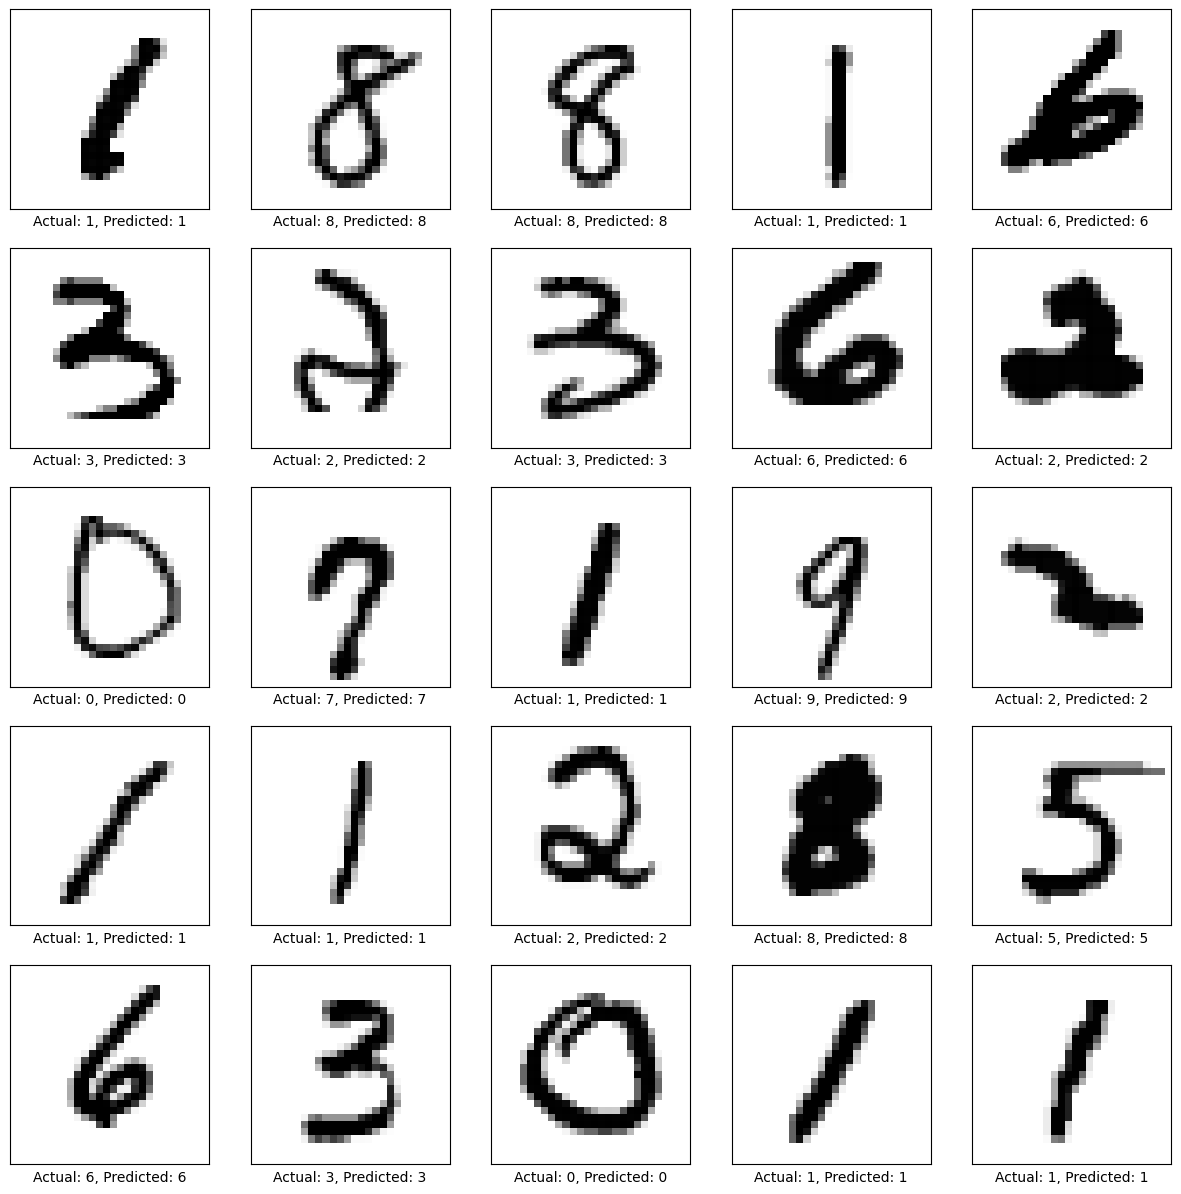

In [44]:
import matplotlib.pyplot as plt

def plot_images(images, labels, predictions):
    # Создаём фигуру с размером 15x15 дюймов
    plt.figure(figsize=(15, 15))
    # Проходимся по 25 изображениям
    for i in range(25):
        # Создаём подплот в сетке 5x5
        plt.subplot(5, 5, i+1)
        # Убираем подписи по осям X и Y
        plt.xticks([])
        plt.yticks([])
        # Убираем сетку
        plt.grid(False)
        # Отображаем изображение в градациях серого
        plt.imshow(images[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
        # Подписываем изображение: Actual (фактическое значение метки) и Predicted (предсказанное значение)
        plt.xlabel(f"Actual: {labels[i]}, Predicted: {predictions[i]}")
    # Отображаем все подплоты
    plt.show()

# Берём первый батч данных из тестового набора
for images, labels in test_dataset.take(1):
    # Делаем предсказания для этих изображений
    predictions = model.predict(images)
    # Получаем метки с наибольшей вероятностью
    predicted_labels = tf.argmax(predictions, axis=1)
    # Вызываем функцию plot_images, передавая изображения, фактические метки и предсказанные метки
    plot_images(images, labels, predicted_labels)

In [51]:
predict_dataset = tf.data.experimental.make_csv_dataset('/content/ML/test.csv',
                                                        batch_size=32,
                                                        shuffle=False,
                                                        num_epochs=1,
                                                        column_names=pixels)

In [52]:
def preproc_fn2(features):
    # Берём все столбцы, соответствующие пикселям изображения
    img_pixels = [features[col] for col in pixels]
    # Создаём тензор из этих пикселей, объединяя их по оси 1
    img_pixels = tf.stack(img_pixels, axis=1)
    # Преобразуем тензор в 4-мерный, где первое измерение - batch size,
    # а последующие 3 - высота, ширина и глубина изображения
    img_pixels = tf.reshape(img_pixels, shape=[-1,28,28,1])
    # Приводим пиксели к значениям в диапазоне [0, 1]
    img_pixels = tf.cast(img_pixels, tf.float32) / 255.0
    return img_pixels

# Применяем функцию preproc_fn2 к датасету predict_dataset
predict_dataset = predict_dataset.map(preproc_fn2)
# Предварительно загружаем данные в буфер, чтобы ускорить обработку
predict_dataset = predict_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

1/1 [==============================] - 0s 48ms/step


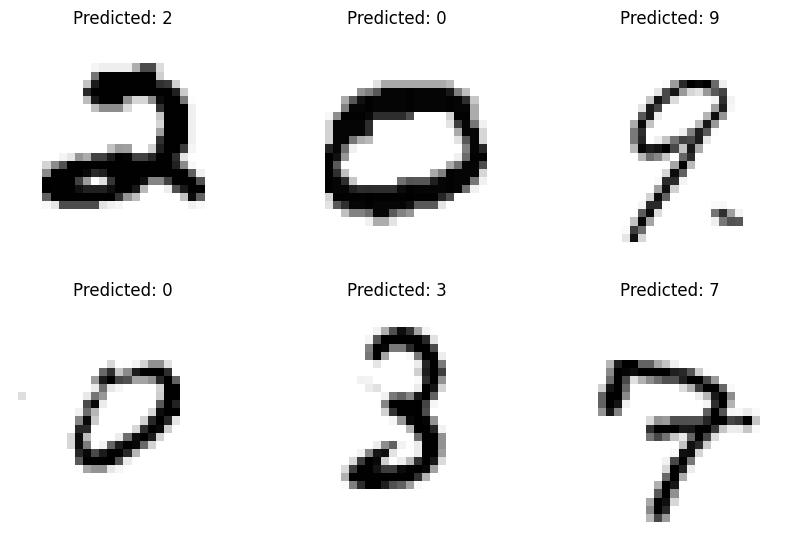

In [53]:
def plot_images(images, predictions, max_images=9):
    # Создаём фигуру с сеткой 3x3 и размером 10x10 дюймов
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        # Проходим по первым max_images изображениям
        if i < max_images:
            # Отображаем изображение
            ax.imshow(images[i].numpy().reshape(28, 28), cmap=plt.cm.binary)
            # Подписываем изображение с предсказанной меткой
            ax.set_title(f"Predicted: {predictions[i]}")
            # Убираем оси
            ax.axis("off")
        # Для остальных подплотов скрываем их
        else:
            ax.set_visible(False)
    # Отображаем фигуру
    plt.show()

# Берём первый батч данных из датасета predict_dataset
for batch in predict_dataset.take(1):
    # Делаем предсказания для этого батча
    predictions = model.predict(batch)
    # Получаем метки с наибольшей вероятностью
    predicted_labels = tf.argmax(predictions, axis=1)
    # Вызываем функцию plot_images, передавая батч изображений, предсказанные метки и максимальное число изображений
    plot_images(batch, predicted_labels, max_images=6)

In [30]:
predictions = model.predict(predict_dataset)
predicted_labels = tf.argmax(predictions, axis=1)

875/875 [==============================] - 39s 41ms/step


In [54]:
df = pd.DataFrame({'ImageId': range(1,len(predicted_labels)+1), 'Label':predicted_labels})
df.to_csv('submission.csv', index=False)